# Classification: Data Modeling

In [1]:
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from os.path import exists

from scipy.stats import uniform
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

pd.set_option('display.max_colwidth', 100)

In [2]:
target = 'tweets'

# The first line for upsampled data, the second for the original data
supervised_up_target_path = f'../dataset/processed/supervised_{target}_upsampled.csv'
supervised_down_target_path = f'../dataset/processed/supervised_{target}_downsampled.csv'
supervised_target_path = f'../dataset/processed/supervised_{target}.csv'

model_path = '../dataset/model/sental_model.pkl'
model_best_params_path = '../dataset/model/svm_best_params.pkl'
vectorizer_path = '../dataset/model/sental_vectorizer.pkl'

In [3]:
# df = pd.read_csv(supervised_target_path, delimiter=';')
df = pd.read_csv(supervised_up_target_path, delimiter=';')
# df = pd.read_csv(supervised_down_target_path, delimiter=';')

df

,index,date,content,text_clean,case_folding,tokens,tokens_ready,review,polarity,sentiment,label
0,0,2022-09-04 23:59:55+00:00,@soeyoto1 @msaid_didu Bukti kalau Pemerintahan Pak @jokowi tidak pro rakyat. Tapi pro oligarki. ...,Bukti kalau Pemerintahan Pak tidak pro rakyat Tapi pro oligarki Vivo BBMnya lebih murah dari Pem...,bukti kalau pemerintahan pak tidak pro rakyat tapi pro oligarki vivo bbmnya lebih murah dari pem...,"['bukti', 'pemerintahan', 'pro', 'rakyat', 'pro', 'oligarki', 'vivo', 'bbmnya', 'murah', 'pemeri...","['bukti', 'perintah', 'pro', 'rakyat', 'pro', 'oligarki', 'vivo', 'bbmnya', 'murah', 'perintah',...",bukti perintah pro rakyat pro oligarki vivo bbmnya murah perintah harga bodoh pertamina,-4,0,Negative
1,1,2022-09-04 23:59:38+00:00,"@KompasTV Mentri esdm, trus patokanmu apa? Kantong pertamina udah jebol karna banyak dikorupsi, ...",Mentri esdm trus patokanmu apa Kantong pertamina udah jebol karna banyak dikorupsi imbasnya raky...,mentri esdm trus patokanmu apa kantong pertamina udah jebol karna banyak dikorupsi imbasnya raky...,"['menteri', 'esdm', 'patokanmu', 'kantong', 'pertamina', 'jebol', 'dikorupsi', 'imbasnya', 'raky...","['menteri', 'esdm', 'patok', 'kantong', 'pertamina', 'jebol', 'korupsi', 'imbas', 'rakyat', 'tan...",menteri esdm patok kantong pertamina jebol korupsi imbas rakyat tanggung,-9,0,Negative
2,4,2022-09-04 23:57:45+00:00,Menteri BUMN Erick Thohir menegaskan persiapan Indonesia soal transisi energi baru terbarukan. S...,Menteri BUMNErick Thohirmenegaskan persiapan Indonesia soal transisi energi baru terbarukan Sala...,menteri bumnerick thohirmenegaskan persiapan indonesia soal transisi energi baru terbarukan sala...,"['menteri', 'bumnerick', 'thohirmenegaskan', 'persiapan', 'indonesia', 'transisi', 'energi', 'te...","['menteri', 'bumnerick', 'thohirmenegaskan', 'indonesia', 'transisi', 'energi', 'salah', 'upaya'...",menteri bumnerick thohirmenegaskan indonesia transisi energi salah upaya kerja pertamina,-2,0,Negative
3,5,2022-09-04 23:57:38+00:00,"Itu kata orang pertamina si wkwkwk, dan hampir setiap hari aku test Sirkulasi franchise Pertamin...",Itu kata orang pertamina wkwkwk dan hampir setiap hari aku test Sirkulasi franchise Pertamina ya...,itu kata orang pertamina wkwkwk dan hampir setiap hari aku test sirkulasi franchise pertamina ya...,"['orang', 'pertamina', 'uji', 'sirkulasi', 'franchise', 'pertamina', 'pertashop', 'berhenti', 'p...","['orang', 'pertamina', 'uji', 'sirkulasi', 'franchise', 'pertamina', 'pertashop', 'henti', 'jual']",orang pertamina uji sirkulasi franchise pertamina pertashop henti jual,-2,0,Negative
4,6,2022-09-04 23:57:00+00:00,@Rama28may @txtdaritng sapa bilang pertamina di korupsi? fitnah !!! mafia pertamina kan sudah di...,sapa bilang pertamina korupsi fitnah mafia pertamina kan sudah basmi ama ahok udah gak ada mafia...,sapa bilang pertamina korupsi fitnah mafia pertamina kan sudah basmi ama ahok udah gak ada mafia...,"['bilang', 'pertamina', 'korupsi', 'fitnah', 'mafia', 'pertamina', 'basmi', 'ahok', 'mafia', 'pe...","['bilang', 'pertamina', 'korupsi', 'fitnah', 'mafia', 'pertamina', 'basmi', 'ahok', 'mafia', 'pe...",bilang pertamina korupsi fitnah mafia pertamina basmi ahok mafia pertamina ahok pertamina surplu...,-19,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...
6573,4805,2022-09-03 13:54:45+00:00,"Wahai kalian yg rindu kemenangan, wahai kalian yg turun ke jalan. Selamat anda tidak jadi kena ...",Wahai kalian rindu kemenangan wahai kalian turun jalan Selamat anda tidak jadi kena prank karena...,wahai kalian rindu kemenangan wahai kalian turun jalan selamat anda tidak jadi kena prank karena...,"['rindu', 'kemenangan', 'turun', 'jalan', 'selamat', 'kena', 'prank', 'harga', 'real', 'pertamin...","['rindu', 'menang', 'turun', 'jalan', 'selamat', 'kena', 'prank', 'harga', 'real', 'pertamina', ...",rindu menang turun jalan selamat kena prank harga real pertamina demo gaji mahasiswa,0,1,Positive
6574,3576,2022-09-04 00:28:03+00:00,Ipda Yuliandi Pa

## Section 1: Term weighting with TF-IDF & Data Splitting

In [4]:
def term_weighting_tfidf(X_train, X_test):
	vectorizer = TfidfVectorizer(use_idf=True, min_df = 5, max_df = 0.8, sublinear_tf = True)

	X_train_tfidf = vectorizer.fit_transform(X_train)
	X_test_tfidf = vectorizer.transform(X_test)
	return X_train_tfidf, X_test_tfidf, vectorizer

def save_vectorizer(model_vectorizer):
  with open(vectorizer_path, 'wb') as f:
    pickle.dump(model_vectorizer, f)

In [5]:
def split_data(test_size=0.2):
		X = df['review']
		y = df['sentiment']
		return train_test_split(X, y, test_size=test_size, random_state=687)

def split_stratified_data(test_size=0.2):
		X = df['review']
		y = df['sentiment']
		return train_test_split(X, y, test_size=test_size, random_state=687, stratify=y)

## Section 2: Classification with SVM

In [6]:
def save_svm_best_param(best_params):
  with open(model_best_params_path, 'wb') as f:
    pickle.dump(best_params, f)

def save_model(model):
  with open(model_path, 'wb') as f:
    pickle.dump(model, f)

def random_best_search_param(X_train_tfidf, y_train):
  param_grid = {'C': uniform(loc=0, scale=4),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': uniform(loc=0, scale=0.1)}
  model = svm.SVC()
  grid_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=0, verbose=1, scoring='accuracy', return_train_score=True, error_score=0.0, refit=True, pre_dispatch='2*n_jobs')
  grid_search.fit(X_train_tfidf, y_train)

  save_svm_best_param(grid_search.best_params_)

  print("Best parameters: ", grid_search.best_params_)
  print("Best score: ", grid_search.best_score_)
  
  return grid_search.best_params_

def load_svm_best_param():
	try:
		with open(model_best_params_path, 'rb') as f:
			return pickle.load(f)
	except FileNotFoundError:
		return None

def load_svm_model(X_train_tfidf, y_train):
    model = None

    if exists(model_path):
      with open(model_path, 'rb') as f:
        model = pickle.load(f)
    else:
      best_params = load_svm_best_param()
      if best_params is None:
        best_params = random_best_search_param(X_train_tfidf, y_train)
        print("Loaded best parameters from grid search")
      else:
        print("Use parameters: ", best_params)
        print("Loaded best parameters from file")
      
      # add probability=True to get probabilities
      model = svm.SVC(**best_params, decision_function_shape='ovr', probability=True)

    print('Parameters: ', model.get_params())
    return model

def model_predict(model, y, y_pred):
	acc = accuracy_score(y, y_pred)
	precision = precision_score(y, y_pred, average='binary')
	recall = recall_score(y, y_pred, average='binary')
	f1 = f1_score(y, y_pred, average='binary')
	matrix = confusion_matrix(y, y_pred)

	print("Accuracy:", acc)
	print("Precision:", precision)
	print("Recall:", recall)
	print("F1-Score:", f1)
	print('Confusion Matrix :')
	print(matrix)
	print('\n Report : ') 
	print(classification_report(y, y_pred))

	f, ax = plt.subplots(figsize=(8,5))
	sns.heatmap(matrix, annot=True, fmt=".0f", ax=ax)
	plt.xlabel("Predicted")
	plt.ylabel("Actual")
	plt.show()

## Section 3: Experiments

### Section 3.1: SVM with TF-IDF (Non-Stratified Data)

In [7]:
X_train, X_test, y_train, y_test = split_data()
X_train_tfidf, X_test_tfidf, vectorizer = term_weighting_tfidf(X_train, X_test)

print('Train data count: ', len(X_train))
print('Train data positive count: ', len(y_train[y_train == 1]))
print('Train data negative count: ', len(y_train[y_train == 0]))
print('Test data count: ', len(X_test))
print('Test data positive count: ', len(y_test[y_test == 1]))
print('Test data negative count: ', len(y_test[y_test == 0]))
print()
print(df.shape)

svm_model = load_svm_model(X_train_tfidf, y_train)
svm_model.fit(X_train_tfidf, y_train)

model_score = svm_model.score(X_test_tfidf, y_test)
print("Model score: ", model_score)

Train data count:  5262
Train data positive count:  2636
Train data negative count:  2626
Test data count:  1316
Test data positive count:  653
Test data negative count:  663

(6578, 11)
Parameters:  {'C': 2.491384382186678, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.06736596308357894, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Model score:  0.8844984802431611


#### Section 3.1.1: Evaluation

Accuracy: 0.8844984802431611
Precision: 0.874439461883408
Recall: 0.8958652373660031
F1-Score: 0.8850226928895613
Confusion Matrix :
[[579  84]
 [ 68 585]]

 Report : 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       663
           1       0.87      0.90      0.89       653

    accuracy                           0.88      1316
   macro avg       0.88      0.88      0.88      1316
weighted avg       0.88      0.88      0.88      1316



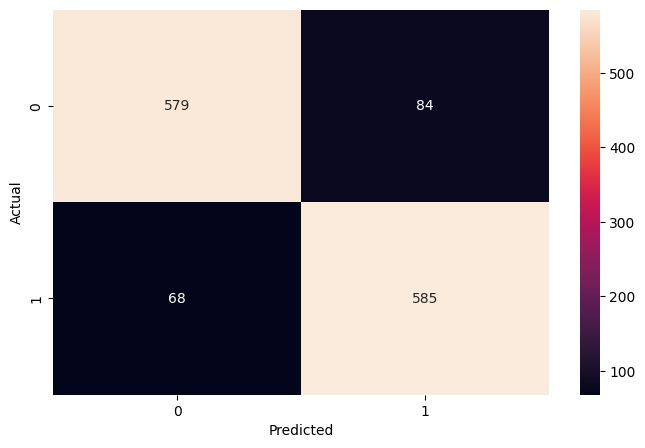

Accuracy: 0.951539338654504
Precision: 0.9359209080922739
Recall: 0.9696509863429439
F1-Score: 0.9524874231414198
Confusion Matrix :
[[2451  175]
 [  80 2556]]

 Report : 
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2626
           1       0.94      0.97      0.95      2636

    accuracy                           0.95      5262
   macro avg       0.95      0.95      0.95      5262
weighted avg       0.95      0.95      0.95      5262



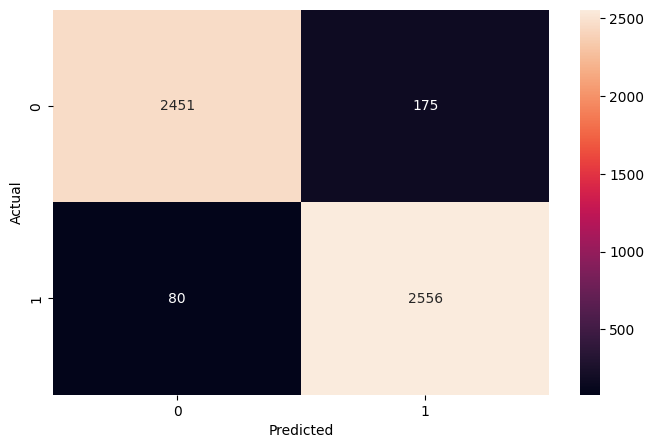

In [8]:
y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test = svm_model.predict(X_test_tfidf)

model_predict(svm_model, y_test, y_pred_test)
model_predict(svm_model, y_train, y_pred_train)

### Section 3.2: SVM with TF-IDF (Stratified Data)

In [9]:
X_train, X_test, y_train, y_test = split_stratified_data()
X_train_tfidf, X_test_tfidf, vectorizer = term_weighting_tfidf(X_train, X_test)

print('Train data count: ', len(X_train))
print('Train data positive count: ', len(y_train[y_train == 1]))
print('Train data negative count: ', len(y_train[y_train == 0]))
print('Test data count: ', len(X_test))
print('Test data positive count: ', len(y_test[y_test == 1]))
print('Test data negative count: ', len(y_test[y_test == 0]))
print()
print(df.shape)

svm_model = load_svm_model(X_train_tfidf, y_train)
svm_model.fit(X_train_tfidf, y_train)

model_score = svm_model.score(X_test_tfidf, y_test)
print("Model score: ", model_score)

Train data count:  5262
Train data positive count:  2631
Train data negative count:  2631
Test data count:  1316
Test data positive count:  658
Test data negative count:  658

(6578, 11)
Parameters:  {'C': 2.491384382186678, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.06736596308357894, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Model score:  0.89209726443769


#### Section 3.2.1: Evaluation

Accuracy: 0.89209726443769
Precision: 0.8717579250720461
Recall: 0.9194528875379939
F1-Score: 0.8949704142011833
Confusion Matrix :
[[569  89]
 [ 53 605]]

 Report : 
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       658
           1       0.87      0.92      0.89       658

    accuracy                           0.89      1316
   macro avg       0.89      0.89      0.89      1316
weighted avg       0.89      0.89      0.89      1316



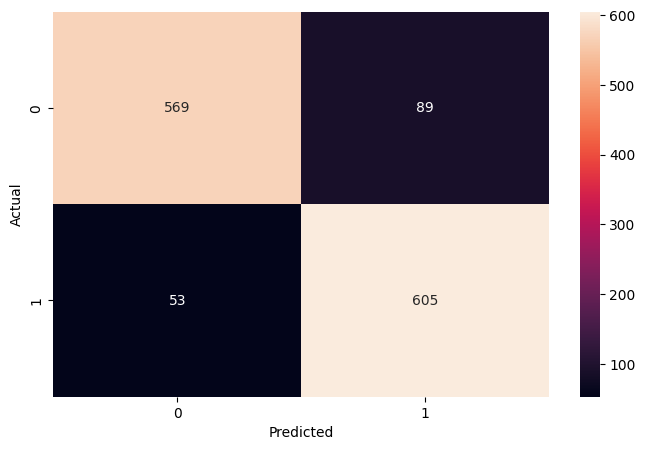

Accuracy: 0.9526795895096921
Precision: 0.9378676470588235
Recall: 0.9695933105283162
F1-Score: 0.9534666417492058
Confusion Matrix :
[[2462  169]
 [  80 2551]]

 Report : 
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2631
           1       0.94      0.97      0.95      2631

    accuracy                           0.95      5262
   macro avg       0.95      0.95      0.95      5262
weighted avg       0.95      0.95      0.95      5262



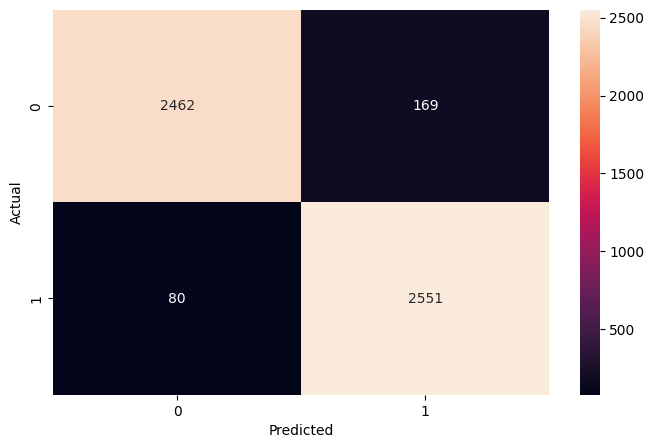

In [10]:
y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test = svm_model.predict(X_test_tfidf)

model_predict(svm_model, y_test, y_pred_test)
model_predict(svm_model, y_train, y_pred_train)

## Section 4: Test & Conclusion

In [11]:
%run "../shared.py"

In [12]:
# Results from prediction sentiment on data test

result_test = pd.DataFrame(data=zip(X_test, y_pred_test), columns=['review', 'code'])

polarity_decode = {0 : 'Negative', 1 : 'Positive'}
result_test['sentiment'] = result_test['code'].map(polarity_decode)

pd.set_option('max_colwidth', 300)
result_test.sample(10)

,review,code,sentiment
496,direktur pertamina mangap vivo jual bbm adu menteri esdm petronas jual murah rakyat nikmat batas,1,Positive
808,korea argyle sweater cardigan ready oversize tags momo sooyoung coming tiffany taki snsd pertamina sambo malming besok senin jungkook seto bts enhypen yuri bohong,0,Negative
447,yah harga pertamina harga ojol,1,Positive
871,serius nanya daftar subsidi pertamina input nmr rangka kendara foto stnk foto ktp aman data isi bensin ribet banget,0,Negative
799,semangat vivo jual harga dukung pertamina butuh kompetitor sehat kayak vivo dkk pertamina sehat biar bangkrut bumn migas kayak toko kelontong amatir,0,Negative
555,harga beli spbu pertamina murah untung,1,Positive
570,gaada atur pertamina hancur pribadi pilih kuning dng skarang selisih ron,0,Negative
69,pertamina anut adil sosial rakyat indonesia distribusi butuh biaya operasional dbandingkan luas wilayah malaysia beda apalgi distribusi lwat laut hutan udara indonesia bgian timur,0,Negative
918,daerah opsi pertamina,0,Negative
135,salur blt makan anggar buanyak banget mending konsumen vivo pajak vivo harga dikit warga senang dana blt kepake pertamina rugi bandar,0,Negative


In [13]:
sample_text = 'Kami Mendukung Keputusan PemeRintah untUk menAIkkan HARga BBM'
sample_text = preprocess_text(sample_text)

sample_text_tfidf = vectorizer.transform([sample_text])
polarity = svm_model.predict(sample_text_tfidf)

sentiment = polarity_decode[polarity[0]]

print(f"Sampel text: {sample_text}")
print(f"Sentiment: {sentiment}")

Normalization list: 1042
Indonesian stopwords: 758
English stopwords: 179
Custom stopwords: 15
Total stopwords: 952
Sampel text: dukung putus perintah naik harga bbm
Sentiment: Positive


In [14]:
sample_text = 'saya benci pemerintah'
sample_text = preprocess_text(sample_text)

sample_text_tfidf = vectorizer.transform([sample_text])
polarity = svm_model.predict(sample_text_tfidf)

sentiment = polarity_decode[polarity[0]]

print(f"Sampel text: {sample_text}")
print(f"Sentiment: {sentiment}")

Normalization list: 1042
Indonesian stopwords: 758
English stopwords: 179
Custom stopwords: 15
Total stopwords: 952
Sampel text: benci perintah
Sentiment: Negative


In [15]:
save_model(svm_model)
save_vectorizer(vectorizer)

## Section 5: Visualizations

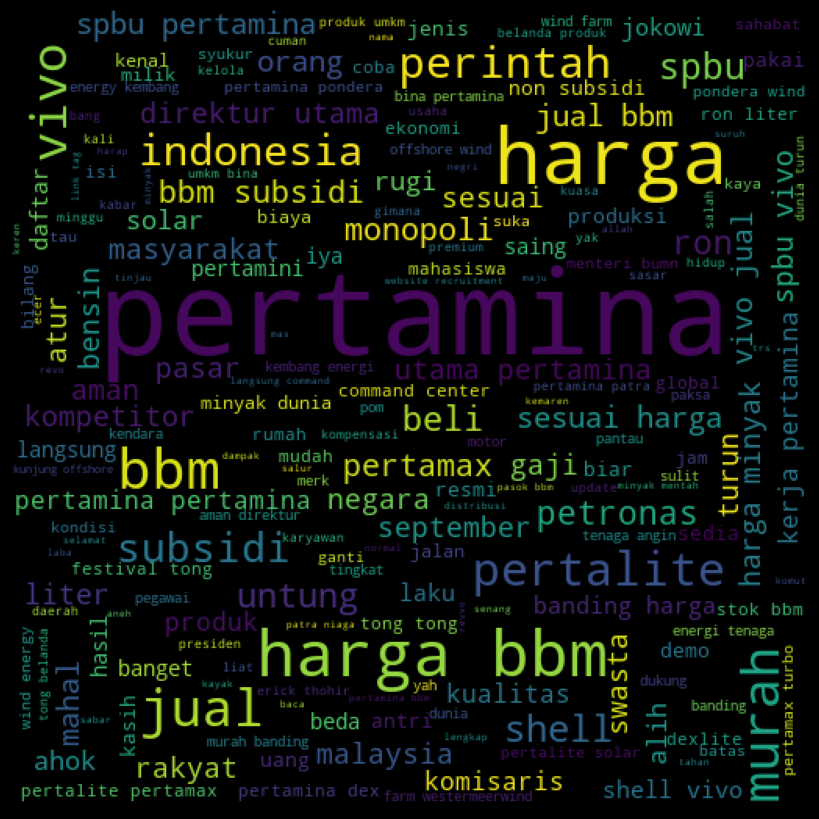

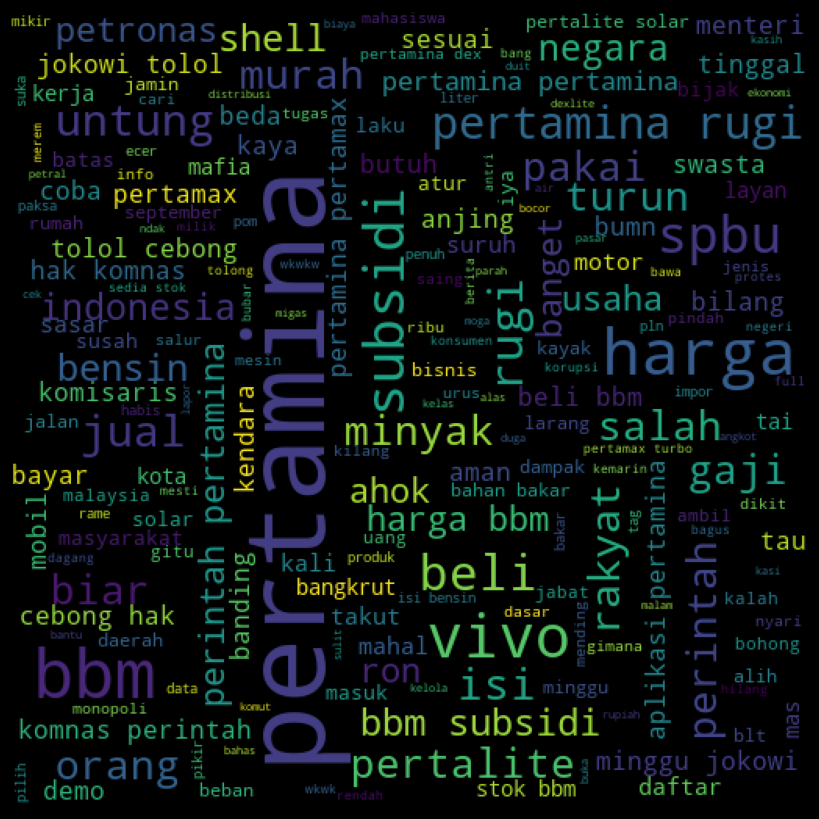

In [16]:
#word cloud for positive review words
pos_words = ' '.join(list(result_test[result_test['code'] == 1]['review']))
pos_wordcloud = WordCloud(width=512,height=512).generate(pos_words)
plt.figure(figsize=(10,8),facecolor = 'k')
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#word cloud for negative review words
neg_words = ' '.join(list(result_test[result_test['code'] == 0]['review']))
neg_wordcloud = WordCloud(width=512,height=512).generate(neg_words)
plt.figure(figsize=(10,8),facecolor = 'k')
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

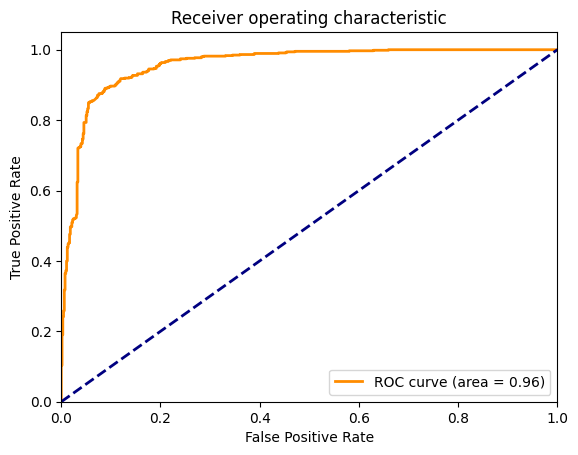

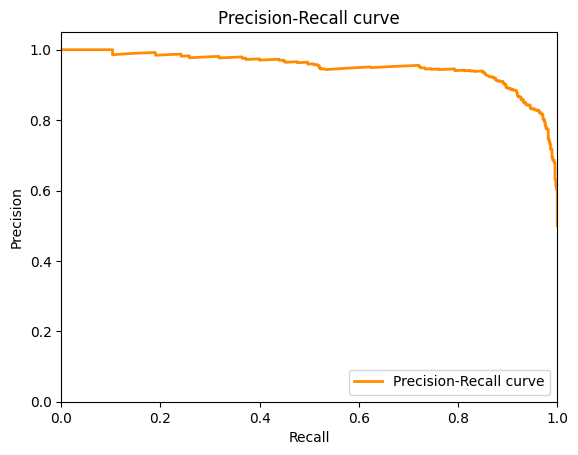

In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, svm_model.predict_proba(X_test_tfidf)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Compute precision-recall
precision, recall, thresholds = precision_recall_curve(y_test, svm_model.predict_proba(X_test_tfidf)[:,1], pos_label=1)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()